In [1]:

from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the ZIP file


Saving cifar-10-python.tar.gz to cifar-10-python.tar.gz


In [2]:
import tarfile # Import tarfile
import os

zip_path = next(iter(uploaded))  # Gets the uploaded file name
extract_path = "unzipped_data"

# Extract
try:
    with tarfile.open(zip_path, 'r:gz') as tar_ref: # Use tarfile.open with 'r:gz' for tar.gz
        tar_ref.extractall(extract_path)
except tarfile.ReadError as e:
    print(f"Error reading tar.gz file: {e}")
    print("Please ensure you uploaded a valid tar.gz file.")

In [3]:
# Import Libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [4]:
# Dataset & Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(root="/content/unzipped_data/cifar-10-batches-py", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


In [5]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# Training Loop (Adversarial Loss)
def train_gan(epochs=50, noise_dim=100, save_path='./generated'):
    generator = Generator(noise_dim).cuda()
    discriminator = Discriminator().cuda()

    loss_fn = nn.BCELoss()
    g_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    os.makedirs(save_path, exist_ok=True)

    for epoch in range(epochs):
        for real, _ in dataloader:
            real = real.view(-1, 784).cuda()
            batch_size = real.size(0)

            # Labels
            real_labels = torch.ones(batch_size, 1).cuda()
            fake_labels = torch.zeros(batch_size, 1).cuda()

            # --- Train Discriminator ---
            z = torch.randn(batch_size, noise_dim).cuda()
            fake = generator(z)
            d_real = discriminator(real)
            d_fake = discriminator(fake.detach())
            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --- Train Generator ---
            z = torch.randn(batch_size, noise_dim).cuda()
            fake = generator(z)
            d_fake = discriminator(fake)
            g_loss = loss_fn(d_fake, real_labels)
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")
            save_image(fake.view(-1, 1, 28, 28), f"{save_path}/epoch_{epoch}.png", normalize=True)

Generated Outputs

In [8]:
# Run training
train_gan(epochs=51)

Epoch 0: D_loss=1.8163, G_loss=0.7240
Epoch 10: D_loss=1.2431, G_loss=0.7111
Epoch 20: D_loss=1.2439, G_loss=0.6139
Epoch 30: D_loss=1.1686, G_loss=1.3724
Epoch 40: D_loss=1.0784, G_loss=0.7882
Epoch 50: D_loss=1.1305, G_loss=0.8160


In [9]:
from google.colab import files
files.download('generated/epoch_10.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
files.download('generated/epoch_20.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
files.download('generated/epoch_30.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
files.download('generated/epoch_40.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
files.download('generated/epoch_50.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

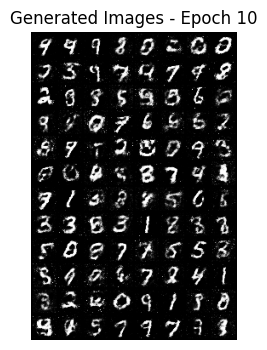

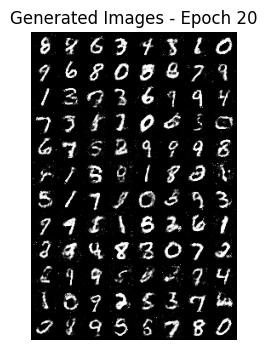

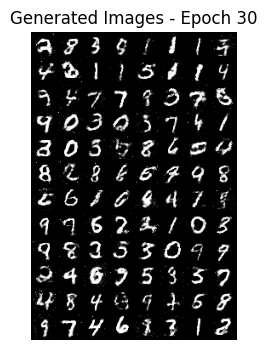

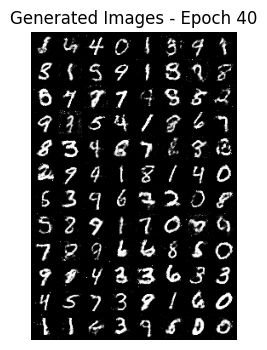

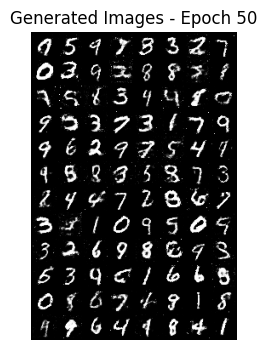

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Show all epoch snapshots
epochs = [10, 20, 30, 40, 50]
for epoch in epochs:
    path = f"generated/epoch_{epoch}.png"
    if os.path.exists(path):
        img = mpimg.imread(path)
        plt.figure(figsize=(4, 4))
        plt.title(f"Generated Images - Epoch {epoch}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"{path} not found.")

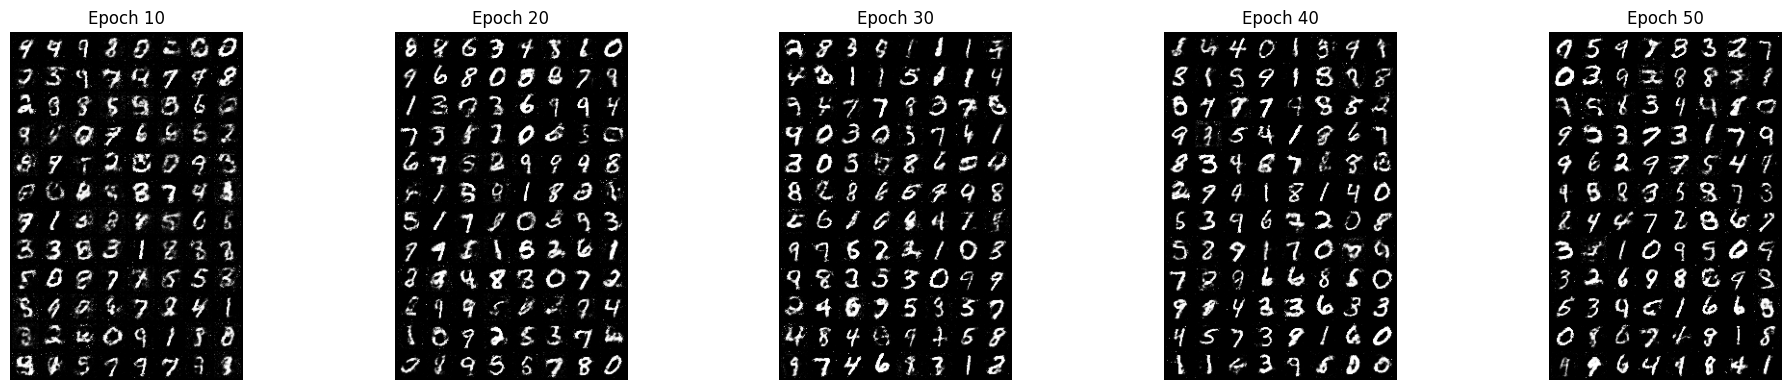

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
epochs = [10, 20, 30, 40, 50]

for i, epoch in enumerate(epochs):
    img_path = f"generated/epoch_{epoch}.png"
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Epoch {epoch}")
        axes[i].axis('off')
    else:
        axes[i].set_title("Not Found")
        axes[i].axis('off')

plt.tight_layout()
plt.show()